In [57]:
import pymc as pm
import arviz as az
import jax.numpy as jnp
import numpy as np
import aesara.tensor as at
from timing import timing_van_jax, comp_gen_D
from modules.polyfit import Polyfit
import json

dummy_fits = Polyfit('dummy_data/fits.npz', input_h5='dummy_data/inputdata.h5', order=3, covariance=True)
coeff = np.array(dummy_fits.p_coeffs)
cov = np.array(dummy_fits.cov)
sd_coeff = np.sqrt(np.diagonal(np.array(cov), axis1=1, axis2=2))
sd_coeff[np.where(sd_coeff==0)]=0.0001
deg=3

#Import target data
with open("dummy_data/target_data.json", 'r') as f:
    target_data = json.loads(f.read())
target_values = np.array([target_data[k][0] for k in target_data])
target_error = np.array([target_data[k][1] for k in target_data])
target_error[np.where(target_error==0)]=0.0001


param_guess = np.array([1.44290955, -0.97476325])
comp = np.array(comp_gen_D(param_guess.size, deg))


with pm.Model() as model:
    p = pm.Normal('params', param_guess, sigma=0.5, shape=np.shape(param_guess))
    #p_poly = pm.Deterministic('p_poly', tt.prod(tt.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True))
    
    true_coeff = pm.Normal('true_coeff', mu=0, sigma=20, shape=np.shape(coeff))
    likelihood_coeff = pm.Normal('x', mu=true_coeff, sigma=sd_coeff, observed=coeff)

    true_y = at.dot(true_coeff, at.prod(at.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True).flatten())
    likelihood_y = pm.Normal('y', mu=true_y, sigma=target_error, observed=target_values)

    step = pm.NUTS(max_treedepth=15)
    trace = pm.sample(100, step, tune=100)

    



Fitting bins: 
/func0#0, /func0#1, /func0#2, /func0#3, /func0#4, /func0#5, /func0#6, /func0#7, /func0#8, /func0#9, /func0#10, /func0#11, /func0#12, /func0#13, /func0#14, /func0#15, /func0#16, /func0#17, /func0#18, /func0#19, /func1#0, /func1#1, /func1#2, /func1#3, /func1#4, /func1#5, /func1#6, /func1#7, /func1#8, /func1#9, /func1#10, /func1#11, /func1#12, /func1#13, /func1#14, /func1#15, /func1#16, /func1#17, /func1#18, /func1#19,  inner loop done!


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [params, true_coeff]
INFO:pymc:NUTS: [params, true_coeff]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 672 seconds.
INFO:pymc:Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 672 seconds.


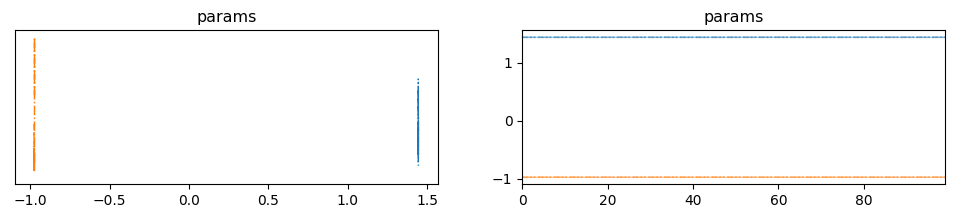

In [58]:
with model:
    az.plot_trace(trace, var_names='params')
    #az.plot_trace(trace, var_names='true_coeff')

In [59]:

"""chain_count = trace.get_values('params').shape[0]
y_pred_g = pm.sample_posterior_predictive(trace, samples=chain_count, model=model)
data_spp = az.from_pymc3(trace=trace, posterior_predictive=y_pred_g)

posterior_params = az.plot_posterior(data_spp, var_names='params', hdi_prob=.95, point_estimate='mean', textsize=20, round_to=4)"""
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
params[0],1.443,0.000,1.443,1.443,0.0,0.0,5.0,14.0,2.40
params[1],-0.975,0.001,-0.976,-0.974,0.0,0.0,5.0,12.0,2.80
"true_coeff[0, 0]",-0.000,0.000,-0.001,0.001,0.0,0.0,5.0,14.0,3.11
"true_coeff[0, 1]",0.000,0.000,-0.000,0.000,0.0,0.0,7.0,12.0,1.76
"true_coeff[0, 2]",0.000,0.000,-0.000,0.000,0.0,0.0,9.0,13.0,1.44
...,...,...,...,...,...,...,...,...,...
"true_coeff[39, 5]",0.000,0.000,-0.000,0.000,0.0,0.0,428.0,199.0,1.01
"true_coeff[39, 6]",0.000,0.000,-0.000,0.000,0.0,0.0,340.0,322.0,1.01
"true_coeff[39, 7]",-0.000,0.000,-0.000,0.000,0.0,0.0,385.0,241.0,1.03
"true_coeff[39, 8]",0.000,0.000,-0.000,0.000,0.0,0.0,477.0,289.0,1.00


In [13]:
p = np.array([1.7, -1.1])
ppoly = np.prod(np.power(p, comp[:, np.newaxis]), axis=2)

y_test = np.dot(coeff, ppoly).flatten()
y_test

array([ 2.52016904e+00,  2.71289422e+00,  3.18039907e+00,  3.96657913e+00,
        3.59322222e+00,  4.11549484e+00,  4.01689136e+00,  3.30343798e+00,
        2.63367937e+00,  2.56086647e+00,  1.87919754e+00,  1.40906992e+00,
        1.03110195e+00,  7.16870738e-01,  4.83734123e-01,  2.50959737e-01,
        1.88127676e-01,  9.34527835e-02,  5.28182149e-02,  2.31283209e-02,
        2.67967415e+00,  3.86748408e+00,  4.47718448e+00,  4.72478416e+00,
        6.92252465e+00,  5.75558934e+00,  5.33826511e+00,  3.62213325e+00,
        2.26485923e+00,  1.12976266e+00,  5.77058655e-01,  1.77958655e-01,
        4.23533946e-02,  8.54697609e-03,  2.33694203e-03,  3.43442150e-04,
       -3.37218607e-06,  7.15163784e-05,  0.00000000e+00,  0.00000000e+00])

In [14]:
from aesara import function
p = at.vector('p')
z_test = at.dot(coeff, at.prod(at.power(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True)).flatten()

f = function([p], z_test)
f(np.array([1.7, -1.1]))

array([ 2.52016904e+00,  2.71289422e+00,  3.18039907e+00,  3.96657913e+00,
        3.59322222e+00,  4.11549484e+00,  4.01689136e+00,  3.30343798e+00,
        2.63367937e+00,  2.56086647e+00,  1.87919754e+00,  1.40906992e+00,
        1.03110195e+00,  7.16870738e-01,  4.83734123e-01,  2.50959737e-01,
        1.88127676e-01,  9.34527835e-02,  5.28182149e-02,  2.31283209e-02,
        2.67967415e+00,  3.86748408e+00,  4.47718448e+00,  4.72478416e+00,
        6.92252465e+00,  5.75558934e+00,  5.33826511e+00,  3.62213325e+00,
        2.26485923e+00,  1.12976266e+00,  5.77058655e-01,  1.77958655e-01,
        4.23533946e-02,  8.54697609e-03,  2.33694203e-03,  3.43442150e-04,
       -3.37218607e-06,  7.15163784e-05,  0.00000000e+00,  0.00000000e+00])

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, true_x]
INFO:pymc:NUTS: [p, true_x]


Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.
INFO:pymc:Sampling 4 chains for 100 tune and 1_000 draw iterations (400 + 4_000 draws total) took 4 seconds.


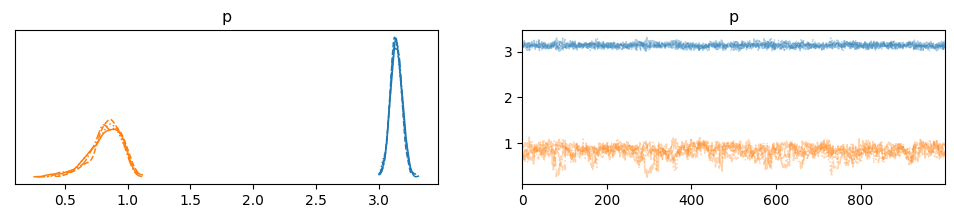

In [53]:
import jax.random as random
import numpy as np
import pymc as pm
import arviz as az

m = 3
c = 1


def f_real(x):
    return m*np.sqrt(x) + m**2*np.sqrt(x) + c

#create x-points of "fake" data
x_max = 1
pt_num = 10
x_dat = np.linspace(0, x_max, pt_num)
x_unc = 0.5*(np.square(x_dat)+x_max/10)/pt_num

#create random abberation in y
key = random.PRNGKey(27)
abrt_scale = 0.1*x_max*m
def f_abrt(x):
    return m*np.sqrt(x) + m**2*np.sqrt(x) + c + abrt_scale*random.normal(key, shape=(x.size,))


f_dat = np.array(f_abrt(x_dat))
comp = np.array([[1,0], [2,0], [0,1]])

with pm.Model() as lin_model:
    p = pm.Normal('p', 0.5, sigma=0.5, shape=(2,)) 
    p_poly = at.prod(at.pow(p, comp[:, np.newaxis]), axis=2, no_zeros_in_input=True).flatten()

    true_x = pm.HalfNormal('true_x', 2*x_max, shape=jnp.shape(x_dat))
    likelihood_x = pm.Normal('x', mu=true_x, sigma=x_unc, observed=x_dat)

    true_f = p_poly[0]*true_x + p_poly[1]*at.sqrt(true_x) + p_poly[2]
    likelihood_f = pm.Normal('f', mu=true_f, sigma=f_dat/20, observed=f_dat)
    

    step_lin = pm.NUTS(max_treedepth=15)
    trace_lin = pm.sample(1000, step_lin, tune=100)


    az.plot_trace(trace_lin, var_names='p')
    




In [38]:
az.summary(trace_lin)
lin_model.basic_RVs

/home/achen8998/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


[p ~ N(0.5, 0.5),
 true_x ~ N(0, 2),
 x ~ N(true_x, <constant>),
 f ~ N(f(true_x, p), <constant>)]

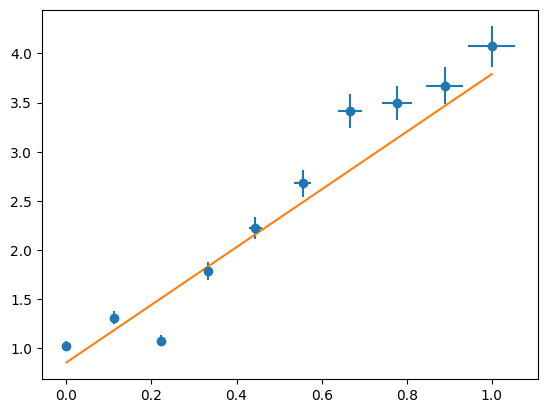

In [57]:
import matplotlib.pyplot as plt

p_fit = jnp.average(jnp.array(trace_lin.posterior.p[0]), axis=0)
p_unc = jnp.std(jnp.array(trace_lin.posterior.p[0]), axis=0)
def f_fit(x):
    return p_fit[0]*x + p_fit[1]

plt.errorbar(x_dat, f_dat, yerr=f_dat/20, xerr=x_unc, fmt='o')
plt.plot(x_dat, f_fit(x_dat))

In [51]:
p = np.array([2, 3])
np.prod(pow(p, comp[:, np.newaxis]), axis=2).flatten()

array([2, 4, 3])